Loading medication data...
Running See function for medA...


/var/folders/g2/lznkhwyd1430dy2980sq86ch0000gn/T/ipykernel_11152/4198775912.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(


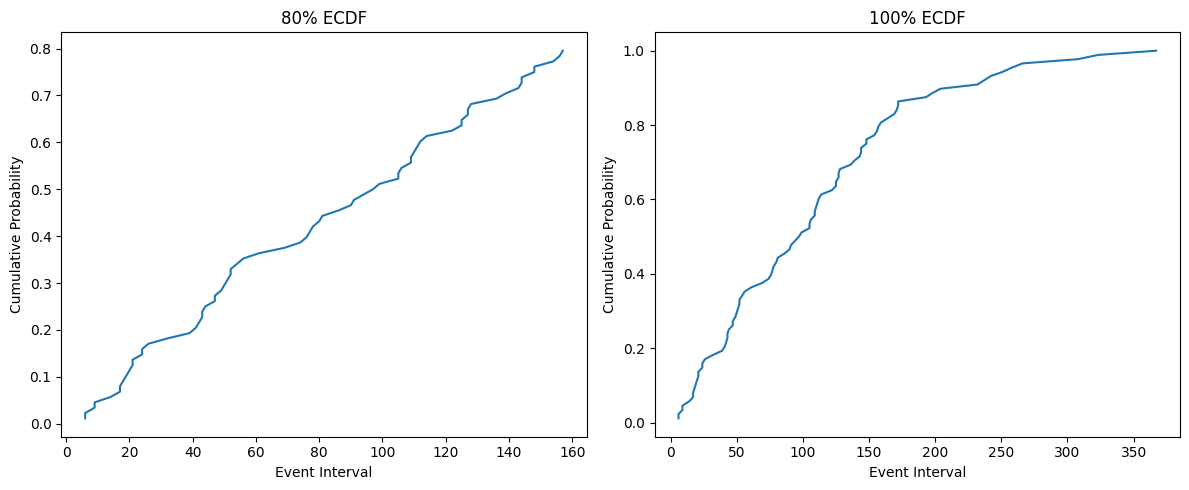

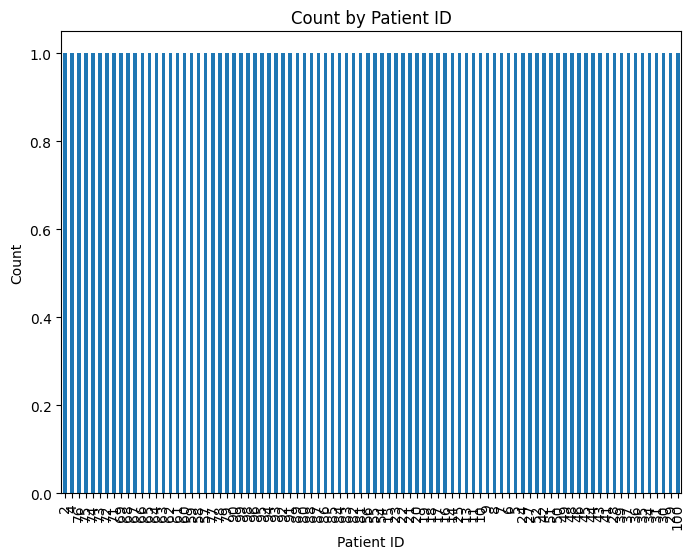

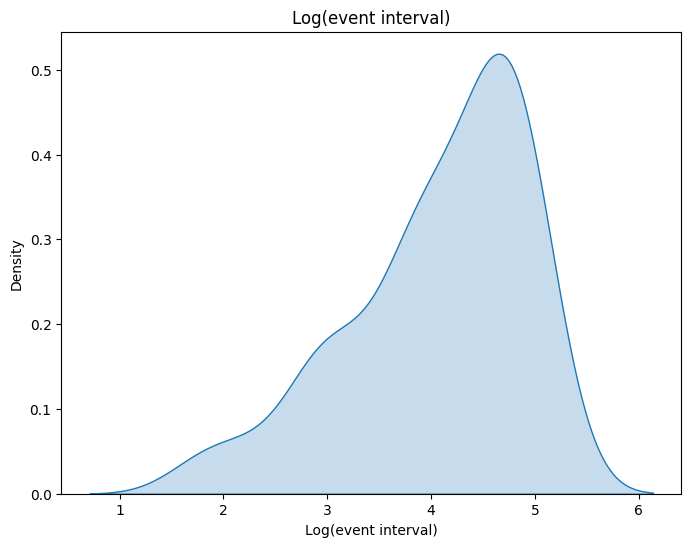

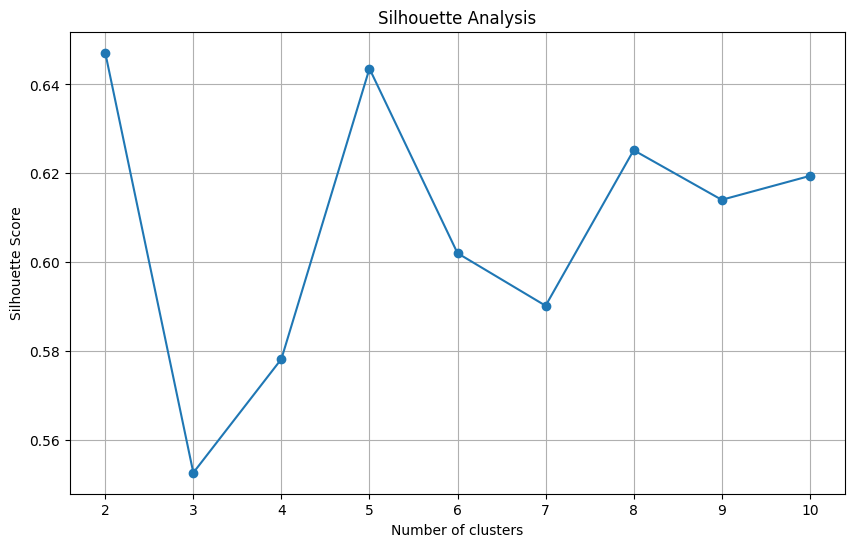

Running See function for medB...


/var/folders/g2/lznkhwyd1430dy2980sq86ch0000gn/T/ipykernel_11152/4198775912.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(


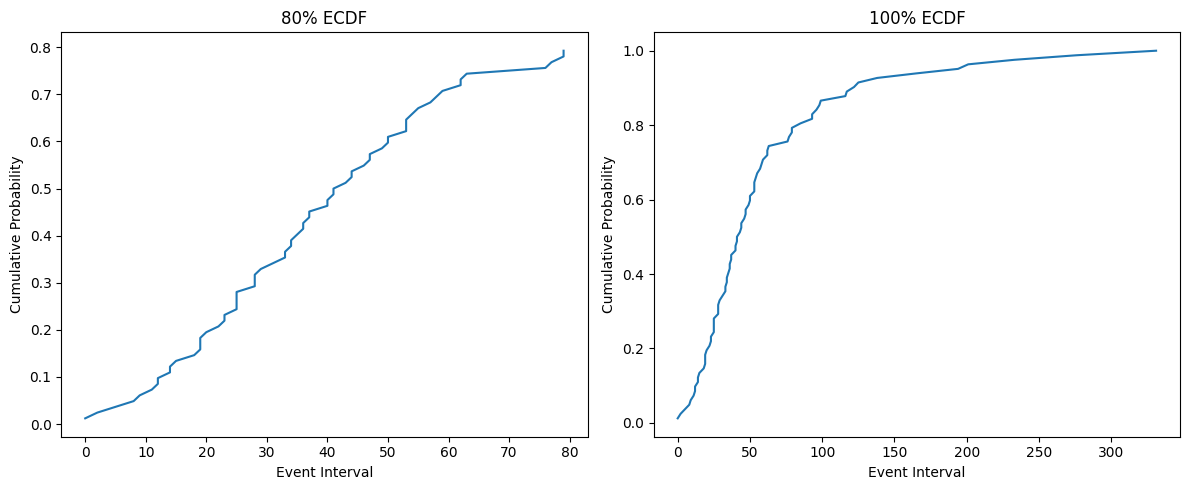

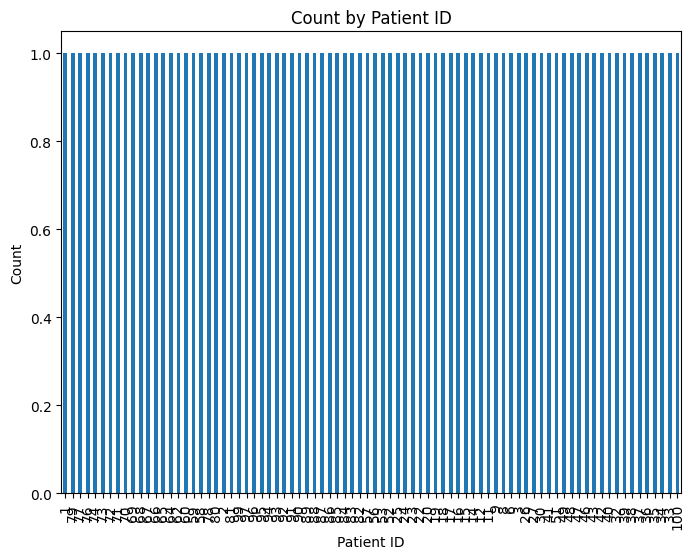

/var/folders/g2/lznkhwyd1430dy2980sq86ch0000gn/T/ipykernel_11152/4198775912.py:110: RuntimeWarning: divide by zero encountered in log
  log_intervals = np.log(Drug_see_p2['event.interval'].values)


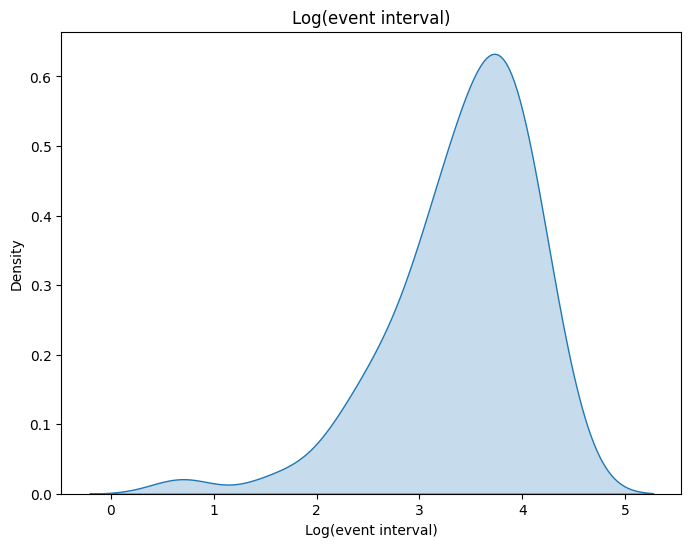

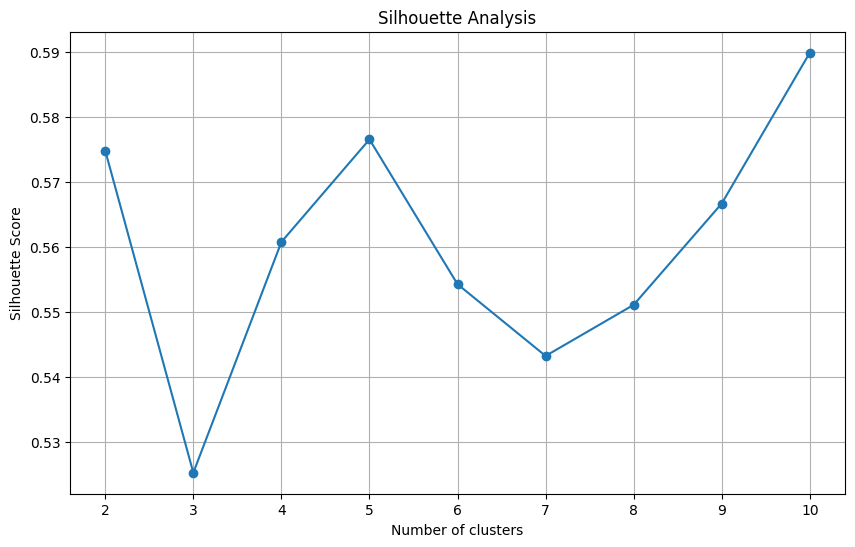

/Users/marymode/Desktop/Assignment_3_Data_Analytics/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generating assumption plots...
Analysis complete. Results saved.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
from datetime import datetime
import os
from matplotlib import gridspec

def load_data(file_path='/Users/marymode/Desktop/Assignment_3_Data_Analytics/med_events.csv'):
    """
    Load and preprocess the medication events data
    """
    # Read the CSV file
    tidy = pd.read_csv(file_path)
    
    # Rename columns to match the R code
    tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    
    # Convert date string to datetime format (assuming MM/DD/YYYY format from mdy in R)
    tidy['eksd'] = pd.to_datetime(tidy['eksd'], errors='coerce')
    
    return tidy

def See(tidy, arg1="medA"):
    """
    Python translation of the See function from R
    Analyzes medication adherence patterns
    
    Parameters:
    tidy (DataFrame): The medication events data
    arg1 (str): The ATC code to analyze (default: "medA")
    
    Returns:
    DataFrame: Processed data with adherence metrics
    """
    # Filter data for the specified ATC code
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    
    # Initial dataset for processing
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    
    # Sort by patient ID and date, then calculate previous prescription date
    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with NA in prev_eksd (equivalent to R's is.na)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Sample one row per patient (ddply equivalent)
    Drug_see_p1 = Drug_see_p1.groupby('pnr').apply(
        lambda x: x.sample(n=1) if len(x) > 0 else x
    ).reset_index(drop=True)
    
    # Select only the needed columns
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    
    # Calculate the date interval
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days
    
    # Create the empirical cumulative distribution
    # Sort data for ECDF calculation
    sorted_intervals = np.sort(Drug_see_p1['event.interval'].values)
    
    # Calculate ECDF values
    y_vals = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
    
    # Create a DataFrame for ECDF
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': y_vals})
    
    # Retain only 80% of the ECDF
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Create plots similar to R
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 80% ECDF
    ax1.plot(dfper['x'], dfper['y'])
    ax1.set_title('80% ECDF')
    ax1.set_xlabel('Event Interval')
    ax1.set_ylabel('Cumulative Probability')
    
    # 100% ECDF
    ax2.plot(sorted_intervals, y_vals)
    ax2.set_title('100% ECDF')
    ax2.set_xlabel('Event Interval')
    ax2.set_ylabel('Cumulative Probability')
    
    plt.tight_layout()
    plt.show()
    
    # Histogram of patients
    plt.figure(figsize=(8, 6))
    Drug_see_p1['pnr'].value_counts().plot(kind='bar')
    plt.title('Count by Patient ID')
    plt.xlabel('Patient ID')
    plt.ylabel('Count')
    plt.show()
    
    # Get the maximum x value from the 80% ECDF
    ni = dfper['x'].max()
    
    # Filter Drug_see_p1 for event intervals <= ni
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni].copy()
    
    # Calculate density of log event interval
    log_intervals = np.log(Drug_see_p2['event.interval'].values)
    
    # Remove infinite values (from log(0))
    log_intervals = log_intervals[np.isfinite(log_intervals)]
    
    # Plot density
    plt.figure(figsize=(8, 6))
    sns.kdeplot(log_intervals, fill=True)
    plt.title('Log(event interval)')
    plt.xlabel('Log(event interval)')
    plt.ylabel('Density')
    plt.show()
    
    # Extract density x and y values
    kernel = stats.gaussian_kde(log_intervals)
    x1 = np.linspace(min(log_intervals), max(log_intervals), 1000)
    y1 = kernel(x1)
    
    # Create a DataFrame for clustering
    a = pd.DataFrame({'x': x1, 'y': y1})
    
    # Scale the data
    a_scaled = (a - a.mean()) / a.std()
    
    # Silhouette analysis to determine optimal number of clusters
    range_n_clusters = list(range(2, 11))
    silhouette_avg_list = []
    
    # Calculate silhouette score for each number of clusters
    for n_clusters in range_n_clusters:
        # Initialize kmeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        cluster_labels = kmeans.fit_predict(dfper[['x']])
        
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(dfper[['x']], cluster_labels)
        silhouette_avg_list.append(silhouette_avg)
    
    # Plot silhouette analysis
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, silhouette_avg_list, 'o-')
    plt.title('Silhouette Analysis')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
    # Get optimal number of clusters
    max_cluster = range_n_clusters[np.argmax(silhouette_avg_list)]
    
    # K-means clustering
    np.random.seed(1234)
    cluster = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = cluster.fit_predict(dfper[['x']])
    
    # Calculate summary statistics by cluster
    cluster_stats = dfper.groupby('cluster')['x'].agg(['min', 'max', 'median']).reset_index()
    
    # Apply log transformation for consistency with R code
    cluster_stats['log_min'] = np.log(cluster_stats['min'])
    cluster_stats['log_max'] = np.log(cluster_stats['max'])
    cluster_stats['log_median'] = np.log(cluster_stats['median'])
    
    # Replace -inf with 0 in log_min (consistent with R code)
    cluster_stats['log_min'] = cluster_stats['log_min'].replace(-np.inf, 0)
    
    # Convert back to original scale
    cluster_stats['min_exp'] = np.exp(cluster_stats['log_min'])
    cluster_stats['max_exp'] = np.exp(cluster_stats['log_max'])
    cluster_stats['median_exp'] = np.exp(cluster_stats['log_median'])
    
    # Rename for clarity
    nif = cluster_stats[['cluster', 'min', 'max', 'median_exp']].rename(
        columns={'min': 'Minimum', 'max': 'Maximum', 'median_exp': 'Median'}
    )
    
    # Filter out rows with Median <= 0
    nif = nif[nif['Median'] > 0]
    
    # Create a cross join (cartesian product) between Drug_see_p1 and nif
    # Reset index to avoid duplicating index in the merge
    Drug_see_p1_reset = Drug_see_p1.reset_index(drop=True)
    nif_reset = nif.reset_index(drop=True)
    
    # Create cartesian product
    results = pd.merge(
        Drug_see_p1_reset,
        nif_reset,
        how='cross'
    )
    
    # Calculate the Final_cluster based on event interval
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']),
        results['cluster'],
        np.nan
    )
    
    # Filter out rows with NA in Final_cluster
    results = results.dropna(subset=['Final_cluster'])
    
    # Prepare the results DataFrame
    results = results[['pnr', 'Median', 'cluster']]
    
    # Find the most frequent cluster
    t1 = results['cluster'].value_counts().reset_index()
    t1.columns = ['Cluster', 'Freq']
    t1 = t1.sort_values('Freq', ascending=False).reset_index(drop=True)
    
    # Get the most frequent cluster
    most_freq_cluster = t1.loc[0, 'Cluster']
    
    # Get the median for the most frequent cluster
    t1_merged = results[results['cluster'] == most_freq_cluster].iloc[0, [0, 1]].to_frame().T
    t1_merged.columns = ['pnr', 'Median']
    t1 = pd.DataFrame({'Median': [t1_merged['Median'].iloc[0]]})
    
    # Merge Drug_see_p1 with results
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left')
    
    # Fill NA values in Median and Cluster
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1['Median'].iloc[0])
    Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna('0')
    
    # Calculate test column
    Drug_see_p1['test'] = (Drug_see_p1['event.interval'] - Drug_see_p1['Median']).round(1)
    
    # Create Drug_see_p3
    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'cluster']]
    
    # Merge Drug_see_p0 with Drug_see_p3
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p3, on='pnr', how='left')
    
    # Fill NA values
    Drug_see_p0['Median'] = pd.to_numeric(Drug_see_p0['Median'])
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1['Median'].iloc[0])
    Drug_see_p0['cluster'] = Drug_see_p0['cluster'].fillna(0)
    
    return Drug_see_p0

def see_assumption(arg1):
    """
    Python translation of the see_assumption function from R
    
    Parameters:
    arg1 (DataFrame): The medication data to analyze
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    # Sort by patient ID and date, then calculate previous prescription date
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    
    # Create Drug_see2 DataFrame
    Drug_see2 = arg1.copy()
    Drug_see2['p_number'] = Drug_see2.groupby('pnr').cumcount() + 1
    
    # Filter for p_number >= 2
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]
    
    # Select required columns
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    
    # Calculate Duration
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    
    # Convert p_number to categorical
    Drug_see2['p_number'] = Drug_see2['p_number'].astype(str)
    
    # Calculate the median duration for each patient
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().reset_index()
    
    # Calculate the overall median of patient-level medians
    overall_median = medians_of_medians['Duration'].median()
    
    # Create the plot using seaborn for better boxplot appearance
    plt.figure(figsize=(10, 6))
    
    # Create boxplot
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    
    # Add horizontal line for overall median
    plt.axhline(y=overall_median, linestyle='--', color='r')
    
    # Style the plot
    plt.title('Duration by Prescription Number')
    plt.xlabel('Prescription Number')
    plt.ylabel('Duration (days)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    return plt.gcf()

def main():
    """
    Main function to run the analysis
    """
    print("Loading medication data...")
    tidy = load_data()
    
    print("Running See function for medA...")
    medA = See(tidy, "medA")
    
    print("Running See function for medB...")
    medB = See(tidy, "medB")
    
    print("Generating assumption plots...")
    fig1 = see_assumption(medA)
    plt.savefig('medA_assumption.png')
    plt.close()
    
    fig2 = see_assumption(medB)
    plt.savefig('medB_assumption.png')
    plt.close()
    
    print("Analysis complete. Results saved.")

if __name__ == "__main__":
    main()